In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("./final_output_1000.csv", usecols=lambda column: column != 'URL')
data.head()

,is_ip,server_client_domain,email_in_url,response_time,qty_ip_resolved,tls_ssl_certificate,qty_redirects,url_shortened,url_google_index,domain_google_index,domain_spf,tld_presencet_params,ttl_value,asn_ip,qty_tld_url,time_domain_activation,time_domain_expiration,qty_mx_servers,phishing
0,0,0,0,-1.000000,0,0,0,0,0,0,-1,1,0,-1,2,212,153,-1,1
1,0,0,0,0.835500,2,0,0,1,0,0,1,1,70,-1,2,5815,2950,5,1
2,0,0,0,6.958606,1,0,0,0,0,0,1,1,86400,-1,2,8028,1468,1,1
3,0,0,0,1.786655,1,0,0,0,0,0,-1,1,55,-1,2,8498,267,1,1
4,0,0,0,1.292164,2,0,0,0,0,0,1,1,60,-1,3,946,149,-1,1


In [3]:
data.shape

(1052, 19)

In [4]:
nulldata = data.isnull().sum()
nulldata[nulldata>0]

Series([], dtype: int64)

In [5]:
x = data.drop(columns = 'phishing')
y = data[['phishing']]
x.shape, y.shape

((1052, 18), (1052, 1))

### Splitting Dataset

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 99)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((736, 18), (316, 18), (736, 1), (316, 1))

In [7]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver = 'liblinear')

In [8]:
classifier.fit(x_train,y_train)

LogisticRegression(solver='liblinear')

In [9]:
y_pred = classifier.predict(x_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8227848101265823

In [10]:
classifier.score(x_train,y_train)

0.8043478260869565

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
col_list = []
for col in data.columns:
    if (col != 'phishing'):
        col_list.append(col)
        
X = data[col_list]
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values,i)
                  for i in range(len(X.columns))]

print(vif_data)

                   feature        VIF
0                    is_ip        NaN
1     server_client_domain   1.002885
2             email_in_url        NaN
3            response_time   1.168482
4          qty_ip_resolved   1.256601
5      tls_ssl_certificate        NaN
6            qty_redirects        NaN
7            url_shortened   1.083195
8         url_google_index        inf
9      domain_google_index        inf
10              domain_spf   1.616467
11    tld_presencet_params  38.799269
12               ttl_value   1.102590
13                  asn_ip   1.079890
14             qty_tld_url   1.187898
15  time_domain_activation   1.962198
16  time_domain_expiration   1.283829
17          qty_mx_servers   1.792186


In [12]:
FI = vif_data[vif_data['VIF']<5]
FI

,feature,VIF
1,server_client_domain,1.002885
3,response_time,1.168482
4,qty_ip_resolved,1.256601
7,url_shortened,1.083195
10,domain_spf,1.616467
12,ttl_value,1.102590
13,asn_ip,1.079890
14,qty_tld_url,1.187898
15,time_domain_activation,1.962198
16,time_domain_expiration,1.283829


In [13]:
x = data[FI.feature]
x.shape

(1052, 11)

In [14]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2)

### importing Classifiers

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

In [16]:
LogReg = LogisticRegression(solver = 'liblinear')
DecisionTree = DecisionTreeClassifier()
RandomForest = RandomForestClassifier()
Naive = BernoulliNB()
SVC = LinearSVC()
XGBoost = XGBClassifier()
LightGBM = LGBMClassifier()
MLP = MLPClassifier()

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

In [44]:
def model_development(model):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    print(f"Test Score = {accuracy_score(y_test,y_pred)}\n")
    print(f"Train Score = {model.score(x_train,y_train)}\n")
    print(f"Classification Report = \n{classification_report(y_test,y_pred)}\n")
    cm = confusion_matrix(y_test,y_pred,labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
    print("Confusion Matrix:\n")
    disp.plot()
    plt.show()
    print(f"ROC AUC Score = {roc_auc_score(y_test,y_pred)}\n")
    print(RocCurveDisplay.from_predictions(y_test,y_pred),"\n")
    roc_curve_display = RocCurveDisplay.from_estimator(model,x_test,y_test)
    print(roc_curve_display,"\n")
    print(f"AUC score from estimators = {roc_curve_display.roc_auc}")
    return {"Training Score":model.score(x_train,y_train),
            "Testing Score":accuracy_score(y_test,y_pred),
           "Classifier AUC score":roc_auc_score(y_test,y_pred),
           "Estimator AUC score":roc_curve_display.roc_auc}

In [19]:
results = {}

### Logistic Regression

Test Score = 0.8246445497630331

Train Score = 0.8097502972651606

Classification Report = 
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       107
           1       0.81      0.85      0.83       104

    accuracy                           0.82       211
   macro avg       0.83      0.82      0.82       211
weighted avg       0.83      0.82      0.82       211


Confusion Matrix:



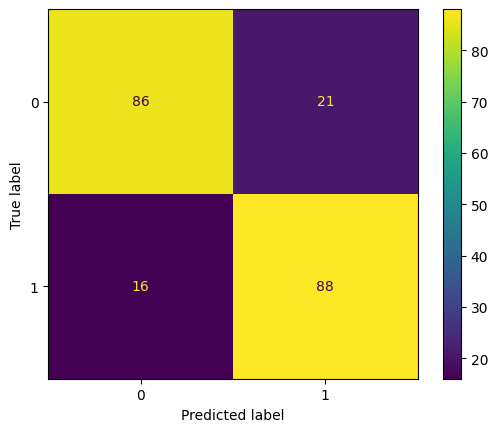

ROC AUC Score = 0.8249460819554278



AUC score from estimators = 0.8785945363048168


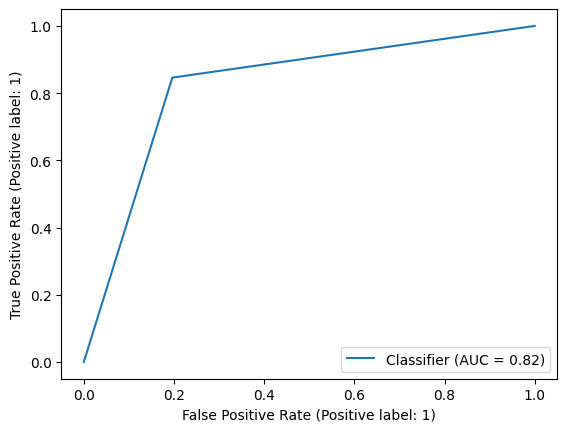

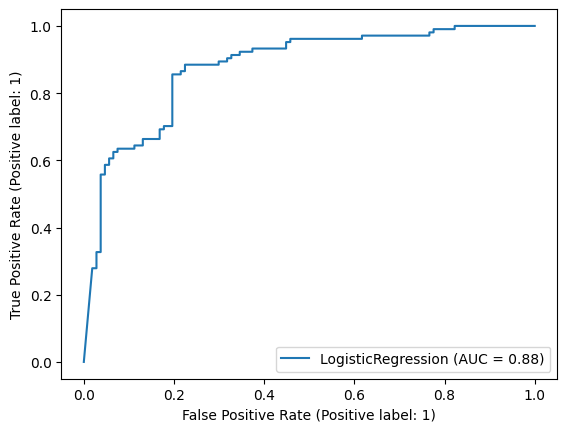

In [45]:
results['Logistic Regression'] = model_development(LogReg)

### Decision Tree


Test Score = 0.8246445497630331

Train Score = 0.990487514863258

Classification Report = 
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       107
           1       0.81      0.85      0.83       104

    accuracy                           0.82       211
   macro avg       0.83      0.82      0.82       211
weighted avg       0.83      0.82      0.82       211


Confusion Matrix:



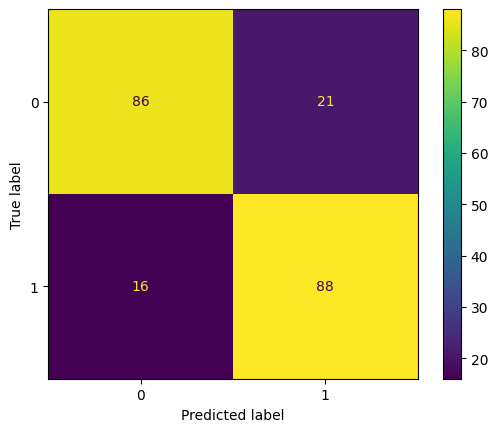

ROC AUC Score = 0.8249460819554278



AUC score from estimators = 0.7893601725377427


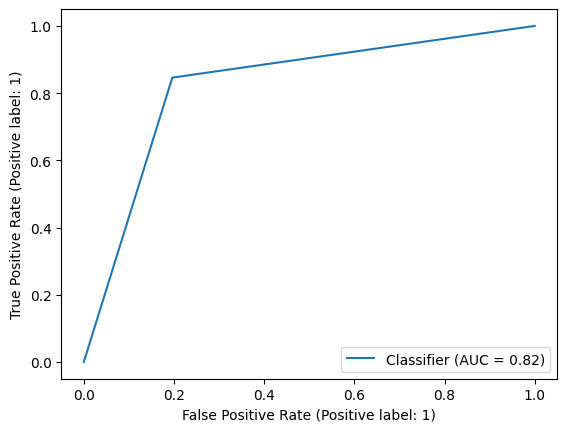

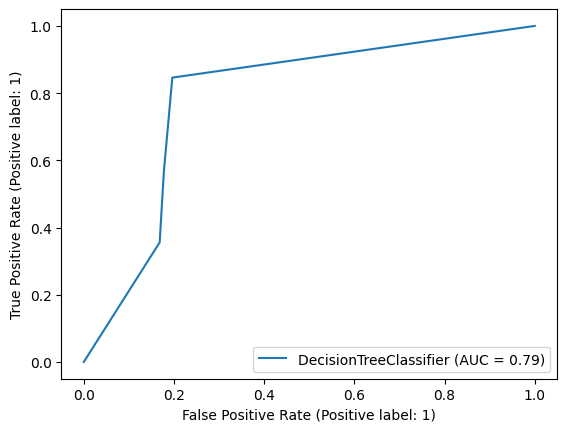

In [46]:
results['Decision Tree'] = model_development(DecisionTree)

### Random Forest Classifier

Test Score = 0.8625592417061612

Train Score = 0.990487514863258

Classification Report = 
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       107
           1       0.83      0.90      0.87       104

    accuracy                           0.86       211
   macro avg       0.86      0.86      0.86       211
weighted avg       0.87      0.86      0.86       211


Confusion Matrix:



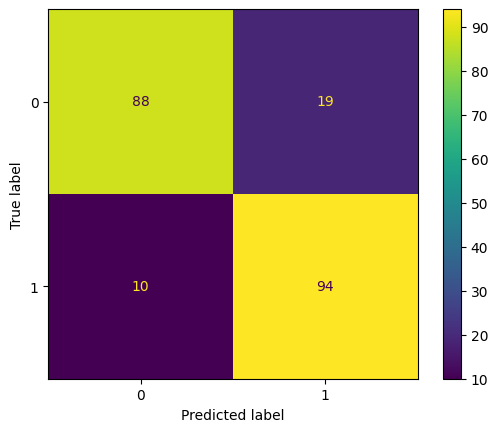

ROC AUC Score = 0.8631380301941048



AUC score from estimators = 0.9456326383896477


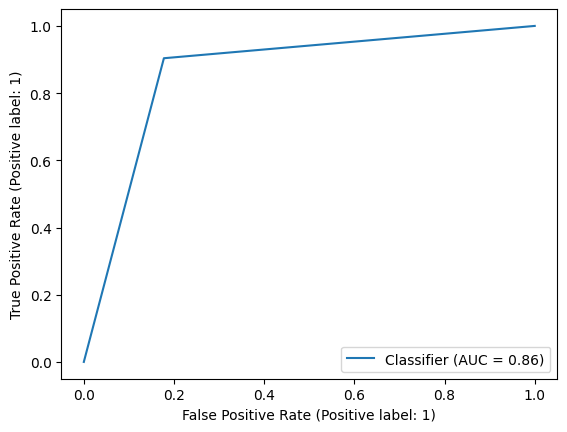

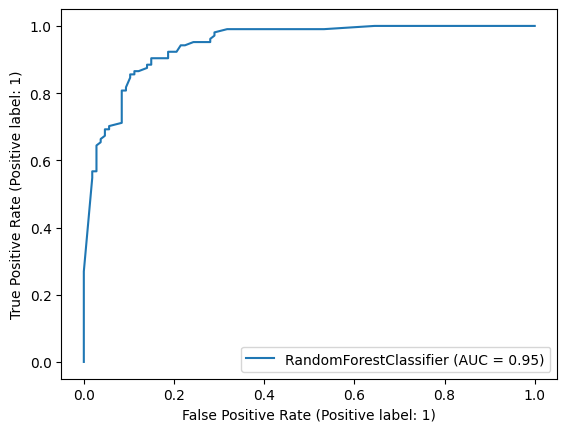

In [47]:
results['Random Forest'] = model_development(RandomForest)


### Naive Bayes

Test Score = 0.7630331753554502

Train Score = 0.7170035671819263

Classification Report = 
              precision    recall  f1-score   support

           0       0.71      0.91      0.80       107
           1       0.86      0.62      0.72       104

    accuracy                           0.76       211
   macro avg       0.79      0.76      0.76       211
weighted avg       0.79      0.76      0.76       211


Confusion Matrix:



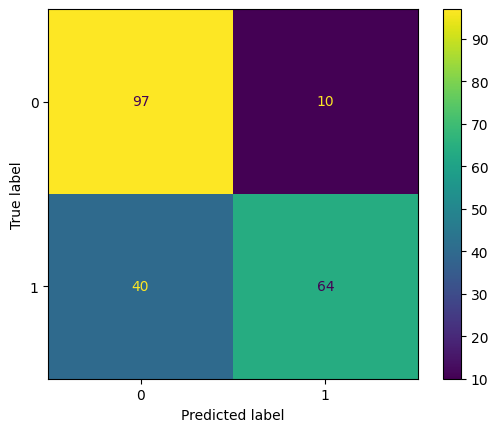

ROC AUC Score = 0.7609633357296909



AUC score from estimators = 0.8262940330697339


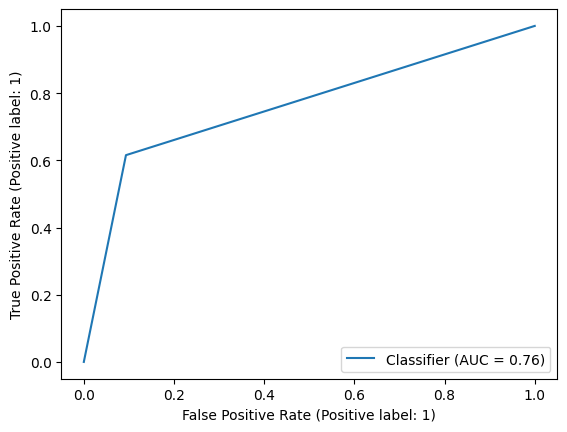

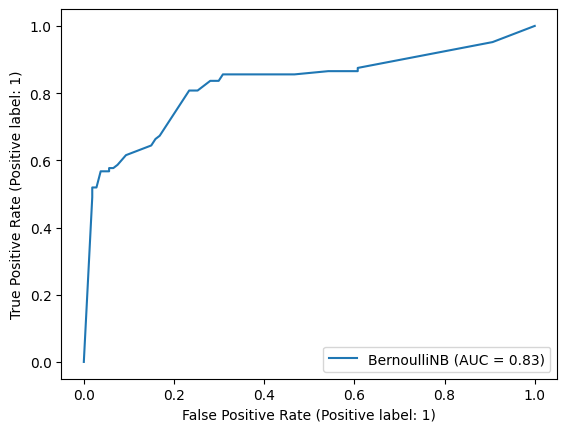

In [48]:
results['Naive Bayes'] = model_development(Naive)

### Support Vector Machine

Test Score = 0.6872037914691943

Train Score = 0.6932223543400713

Classification Report = 
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       107
           1       0.66      0.76      0.71       104

    accuracy                           0.69       211
   macro avg       0.69      0.69      0.69       211
weighted avg       0.69      0.69      0.69       211


Confusion Matrix:



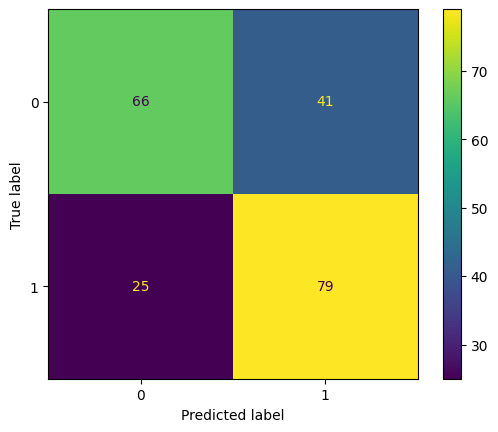

ROC AUC Score = 0.6882189072609635



AUC score from estimators = 0.642882818116463


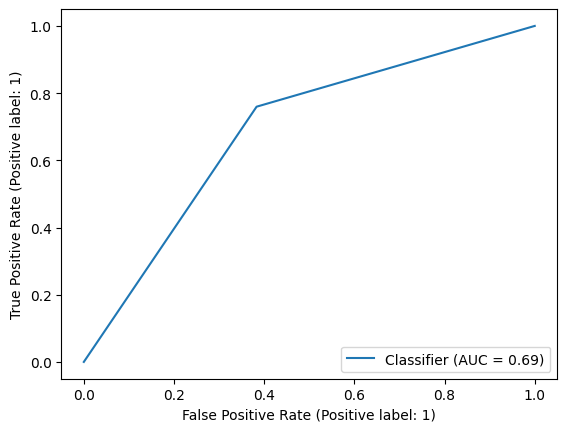

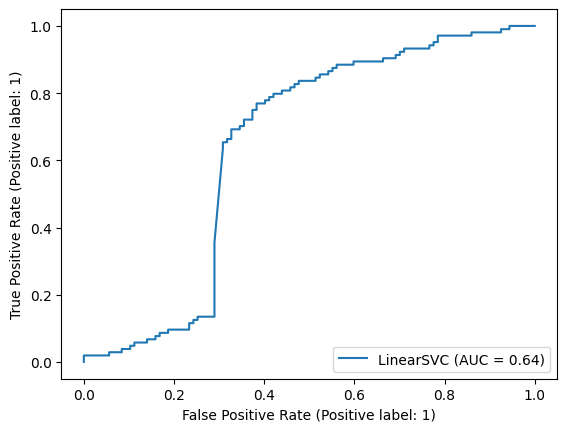

In [49]:
results['Support Vector Machine'] = model_development(SVC)

### XG Boost Classifier

Test Score = 0.8672985781990521

Train Score = 0.990487514863258

Classification Report = 
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       107
           1       0.84      0.90      0.87       104

    accuracy                           0.87       211
   macro avg       0.87      0.87      0.87       211
weighted avg       0.87      0.87      0.87       211


Confusion Matrix:



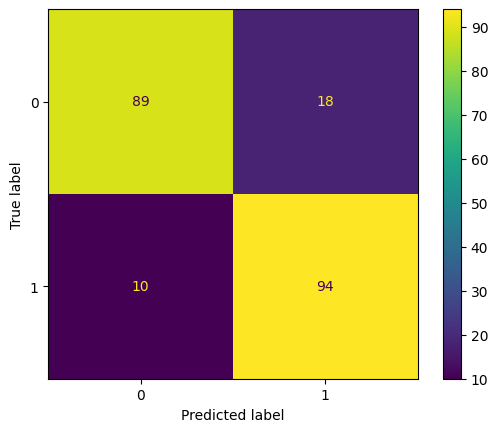

ROC AUC Score = 0.8678109273903666



AUC score from estimators = 0.9318386053199137


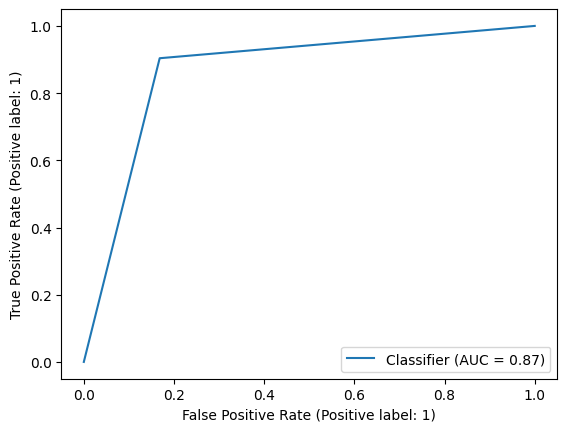

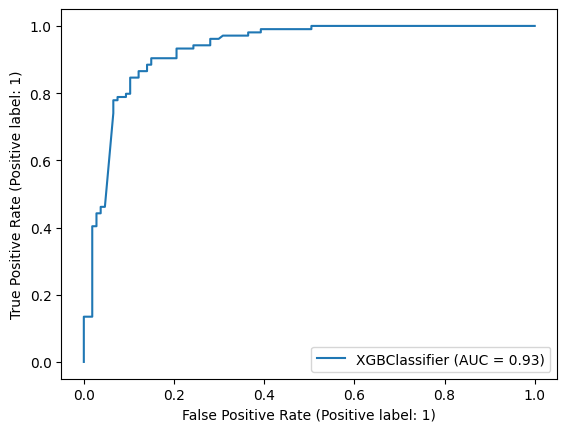

In [51]:
results['XG Boost'] = model_development(XGBoost)

### Light GBM Classifier

[LightGBM] [Info] Number of positive: 441, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.524376 -> initscore=0.097580
[LightGBM] [Info] Start training from score 0.097580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

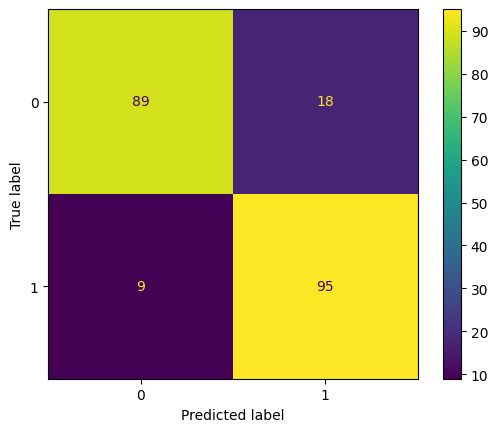

ROC AUC Score = 0.8726186196980589



AUC score from estimators = 0.9340851905104242


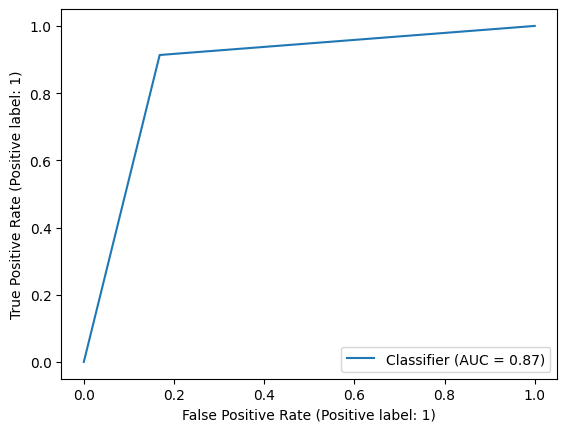

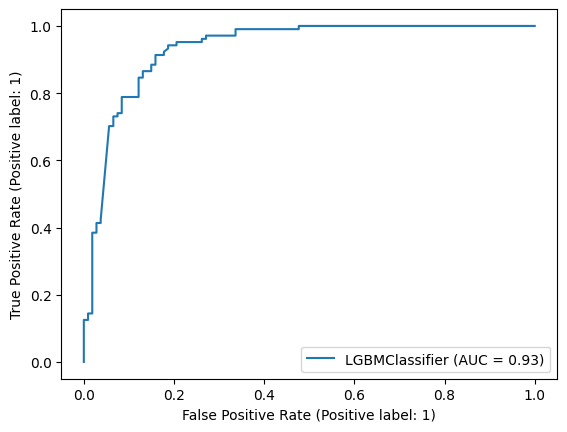

In [54]:
results['Light GBM'] = model_development(LightGBM)

### Multilayer Perceptron Neural Network

Test Score = 0.7014218009478673

Train Score = 0.7312722948870393

Classification Report = 
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       107
           1       0.74      0.62      0.67       104

    accuracy                           0.70       211
   macro avg       0.71      0.70      0.70       211
weighted avg       0.71      0.70      0.70       211


Confusion Matrix:



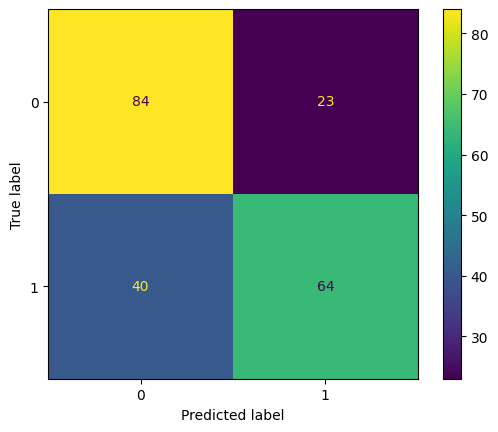

ROC AUC Score = 0.7002156721782891



AUC score from estimators = 0.7903486700215673


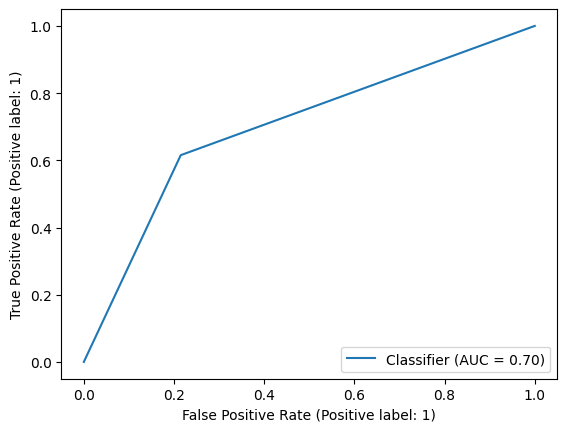

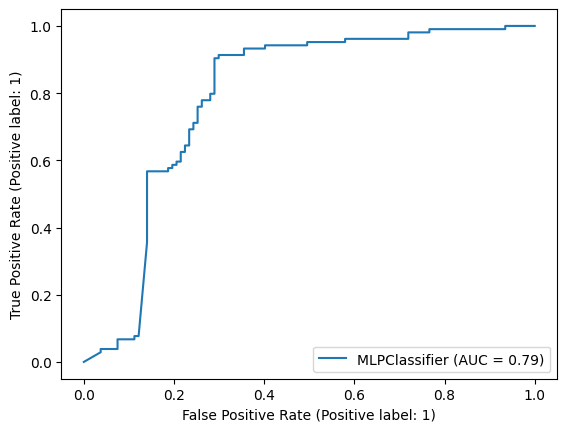

In [52]:
results['MLP Neural Network'] = model_development(MLP)

In [53]:
results_df = pd.DataFrame(results)
results_df 

,Logistic Regression,Decision Tree,Random Forest,Naive Bayes,Support Vector Machine,Light GBM,XG Boost,MLP Neural Network
Training Score,0.809750,0.990488,0.990488,0.717004,0.693222,0.989298,0.990488,0.731272
Testing Score,0.824645,0.824645,0.862559,0.763033,0.687204,0.872038,0.867299,0.701422
Classifier AUC score,0.824946,0.824946,0.863138,0.760963,0.688219,0.872619,0.867811,0.700216
Estimator AUC score,0.878595,0.789360,0.945633,0.826294,0.642883,0.934085,0.931839,0.790349


In [23]:
import pickle

# 將模型保存為 PKL 檔案
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(classifier, file)